In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

see https://canvas.ox.ac.uk/courses/214847/pages/2-dot-5-eeg-biomarkers-and-applications-of-machine-learning-aleksandra-vuckovic-12-dot-12-dot-23?module_item_id=2163271

In [2]:
import logging
from pathlib import Path

import holoviews as hv
import matplotlib.pyplot as plt
import mne
import plotly.io as pio
import polars as pl

from src.data.config_data_interim import INTERIM_DICT, INTERIM_LIST, InterimConfig
from src.data.config_data_raw import RAW_DICT, RAW_LIST, RawConfig
from src.data.config_participant import PARTICIPANT_LIST, ParticipantConfig
from src.data.make_dataset import load_dataset, load_participant_datasets
from src.data.utils import load_modality_data, merge_datasets
from src.data.quality_checks import check_sample_rate
from src.features.scaling import scale_min_max, scale_standard
from src.features.stimulus import corr_temperature_rating
from src.features.transforming import (
    add_timedelta_column,
    interpolate,
    map_participant_datasets,
    map_trials,
)
from src.helpers import to_describe
from src.log_config import configure_logging
from src.plots.plot_data import (
    plot_data_panel,
    plot_trial_matplotlib,
    plot_trial_plotly,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

ModuleNotFoundError: No module named 'src.data.config_data_interim'

In [4]:
dfs = load_participant_datasets(PARTICIPANT_LIST[0], INTERIM_LIST)
eeg = dfs.eeg
eeg

20:30:35 | DEBUG   | make_dataset | Dataset 'stimulus' for participant 1 loaded from data/interim/1/1_stimulus.csv
20:30:35 | DEBUG   | make_dataset | Dataset 'eeg' for participant 1 loaded from data/interim/1/1_eeg.csv
20:30:35 | DEBUG   | make_dataset | Dataset 'eda' for participant 1 loaded from data/interim/1/1_eda.csv
20:30:35 | DEBUG   | make_dataset | Dataset 'ppg' for participant 1 loaded from data/interim/1/1_ppg.csv
20:30:35 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 1 loaded from data/interim/1/1_pupillometry.csv
20:30:35 | DEBUG   | make_dataset | Dataset 'affectiva' for participant 1 loaded from data/interim/1/1_affectiva.csv
20:30:35 | INFO    | make_dataset | Participant 1 loaded with datasets: dict_keys(['stimulus', 'eeg', 'eda', 'ppg', 'pupillometry', 'affectiva'])


Timestamp,EEG_RAW_Ch1,EEG_RAW_Ch2,EEG_RAW_Ch3,EEG_RAW_Ch4,EEG_RAW_Ch5,EEG_RAW_Ch6,EEG_RAW_Ch7,EEG_RAW_Ch8,Participant,Trial
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
294197.3945,9948.540039,12283.850586,5801.344238,18263.294922,12240.93457,17119.123047,13553.095703,5451.536133,1.0,0.0
294200.3867,9941.483398,12282.277344,5801.916016,18267.203125,12242.74707,17122.318359,13557.387695,5453.300781,1.0,0.0
294202.5715,9942.960938,12290.860352,5800.676758,18270.494141,12251.998047,17126.800781,13561.726562,5462.074219,1.0,0.0
294204.4057,9963.942383,12311.935547,5811.35791,18279.601562,12267.97168,17134.095703,13567.115234,5467.701172,1.0,0.0
294206.6215,9981.442383,12317.563477,5804.109863,18269.015625,12266.636719,17120.648438,13552.333008,5452.824219,1.0,0.0
294208.5568,9996.795898,12321.043945,5787.086914,18254.662109,12260.152344,17105.152344,13534.927734,5438.041992,1.0,0.0
…,…,…,…,…,…,…,…,…,…,…
3.0293e6,7258.605957,10099.458984,1113.557007,14735.174805,12096.500977,13281.632812,11205.817383,4664.420898,1.0,11.0
3.0293e6,7257.223145,10092.926758,1096.296021,14718.676758,12083.150391,13264.705078,11189.890625,4648.495117,1.0,11.0


In [5]:
features = [
    "EEG_RAW_Ch1",
    "EEG_RAW_Ch2",
    "EEG_RAW_Ch3",
    "EEG_RAW_Ch4",
    "EEG_RAW_Ch5",
    "EEG_RAW_Ch6",
    "EEG_RAW_Ch7",
    "EEG_RAW_Ch8",
]
eeg.hvplot(
    x="Timestamp",
    y=features,
    groupby=["Participant", "Trial"],
    kind="line",
    width=1300,
    height=400,
    ylim=(0, 1),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7d933daa-9c2e-46ee-be21-e38b27269580': {'version…

In [48]:
eeg_ch = (
    eeg.filter(pl.col("Trial") == 1).select(pl.col("EEG_RAW_Ch5")).to_numpy().flatten()
)
eeg_ch

array([11961.55566406, 11958.45703125, 11950.3984375 , ...,
       11560.10742188, 11559.00976562, 11557.34082031])

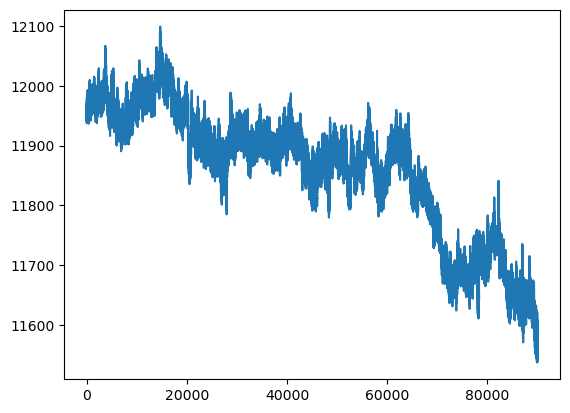

In [49]:
plt.plot(eeg_ch)

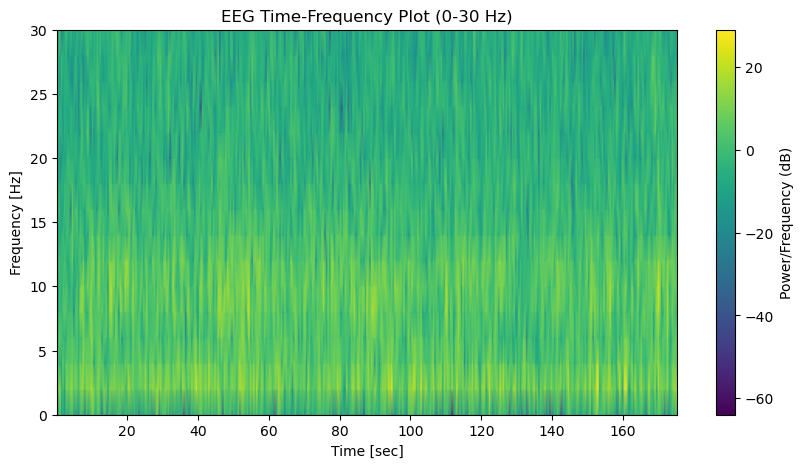

In [50]:
sampling_rate = 512  # Replace with your EEG's sampling rate in Hz
low_freq = 0
high_freq = 30

from scipy.signal import spectrogram

# Computing the spectrogram
frequencies, times, spectrogram_data = spectrogram(eeg_ch, fs=sampling_rate)

# Limiting the spectrogram to the frequency range of interest
freq_indices = (frequencies >= low_freq) & (frequencies <= high_freq)
frequencies = frequencies[freq_indices]
spectrogram_data = spectrogram_data[freq_indices, :]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram_data), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.title("EEG Time-Frequency Plot (0-30 Hz)")
plt.colorbar(label="Power/Frequency (dB)")
plt.ylim(low_freq, high_freq)  # show only 0-30 Hz
plt.show()

<Axes: xlabel='Timestamp'>

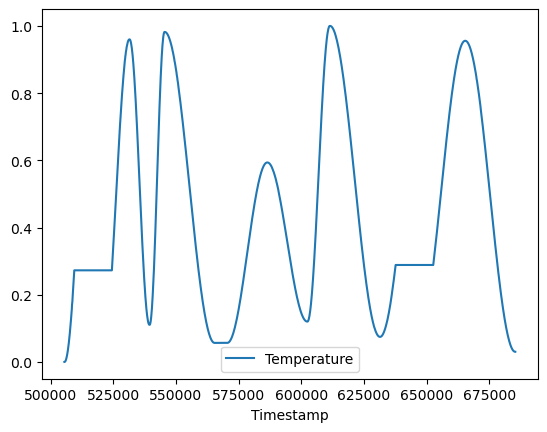

In [47]:
dfs.stimulus.filter(pl.col("Trial") == 1).to_pandas().plot(
    x="Timestamp", y="Temperature"
)

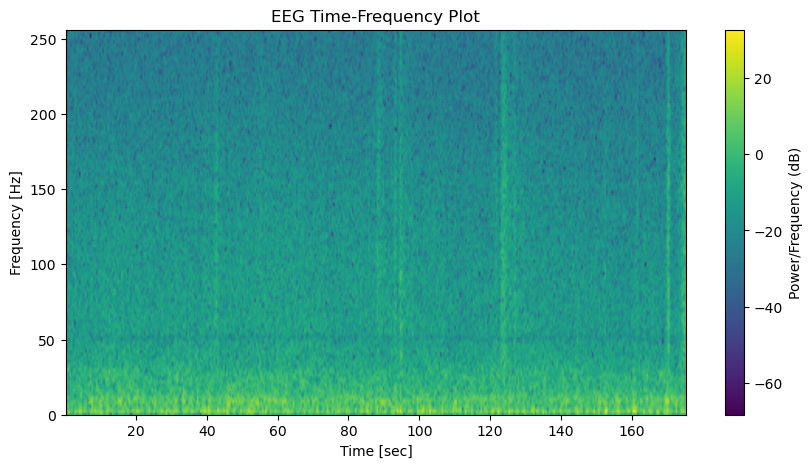

In [36]:
from scipy.signal import spectrogram
import numpy as np

from scipy.signal import iirnotch, filtfilt

# Define the notch filter frequency and quality factor
notch_freq = 50  # Frequency to be removed from signal (Hz)
quality_factor = 30  # Quality factor

# Sampling rate
sampling_rate = 500  # Replace 256 with your actual EEG sampling rate in Hz

# Design notch filter
b, a = iirnotch(notch_freq, quality_factor, sampling_rate)

# Apply the filter
filtered_eeg = filtfilt(b, a, eeg_ch)


# Assuming the EEG data is in one channel
frequencies, times, spectrogram_data = spectrogram(filtered_eeg, fs=512)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram_data), shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.title("EEG Time-Frequency Plot")
plt.colorbar(label="Power/Frequency (dB)")
plt.show()

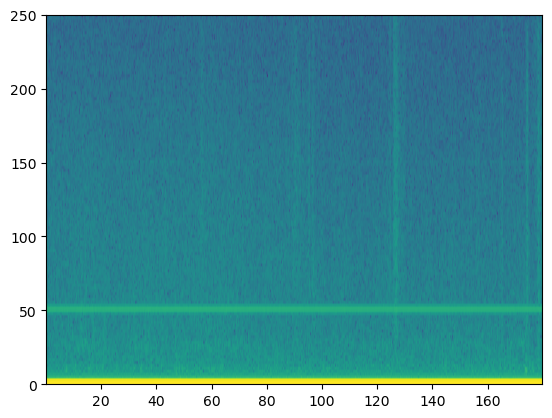

In [7]:
_ = plt.specgram(eeg_ch, Fs=500)

## MNE

In [8]:
sampling_rate = 500

# Convert to numpy array and transpose to get channels x timeseries
eeg_data = eeg.select(pl.col("^EEG_.*$")).to_numpy().T

# Create the info structure needed by MNE
ch_names = [
    "EEG 001",
    "EEG 002",
    "EEG 003",
    "EEG 004",
    "EEG 005",
    "EEG 006",
    "EEG 007",
    "EEG 008",
]
ch_types = ["eeg"] * 8
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)
raw.filter(l_freq=1.0, h_freq=40.0)  # Band-pass filtering

raw

Creating RawArray with float64 data, n_channels=8, n_times=1080059
    Range : 0 ... 1080058 =      0.000 ...  2160.116 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/var/folders/54/0yy_ylvj7tx247wkq0n07dnr0000gn/T/ipykernel_16526/2174347421.py:1: FutureWarning:

The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.

/Users/visser/miniforge3/envs/pain/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



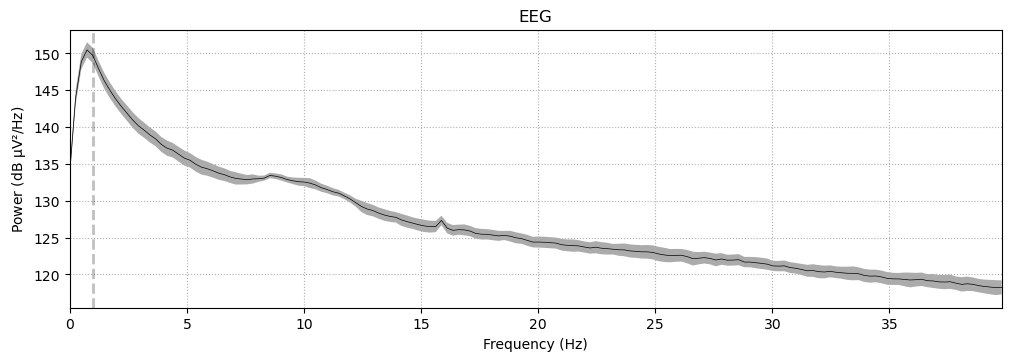

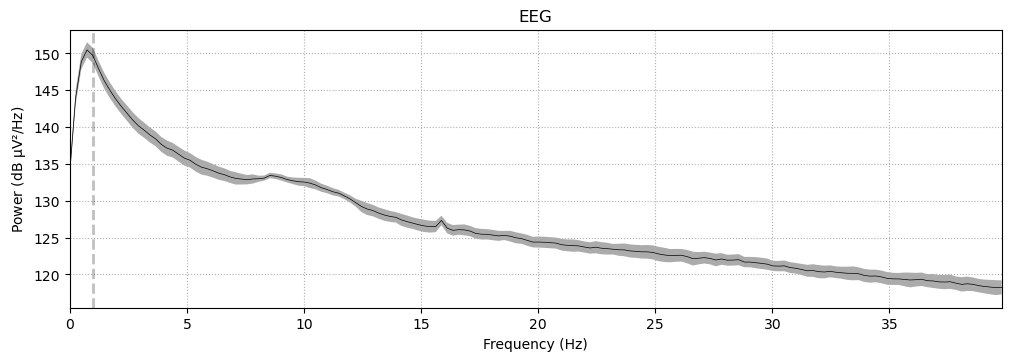

In [9]:
raw.plot_psd(fmax=40, average=True)

In [10]:
raw.filter(l_freq=1.0, h_freq=40.0)  # Band-pass filtering

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [11]:
events = mne.find_events(raw, stim_channel="STI 014")

# Construct Epochs
event_id, tmin, tmax = 1, -1.0, 3.0
baseline = (None, 0)
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=baseline,
    reject=dict(grad=4000e-13, eog=350e-6),
    preload=True,
)

ValueError: Missing channels from ch_names required by include:
['STI 014']

In [ ]:
# Define a dictionary mapping old channel names to new ones
new_channel_names = {
    "EEG 001": "F3",
    "EEG 002": "F4",
    "EEG 003": "C3",
    "EEG 004": "Cz",
    "EEG 005": "C4",
    "EEG 006": "P3",
    "EEG 007": "P4",
    "EEG 008": "Oz",
}

# Rename channels
raw.rename_channels(new_channel_names)

# Optionally, set the type of channels if not already set
channel_types = {name: "eeg" for name in new_channel_names.values()}
raw.set_channel_types(channel_types)

# Check the new configuration
raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [ ]:
raw.filter(l_freq=1.0, h_freq=40.0)  # Band-pass filtering
raw.notch_filter(freqs=50)  # Notch filter at 50 Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edg

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [ ]:
start_stop_seconds = np.array([30, 210])  # Example: analyzing data from 30s to 210s
start_sample, stop_sample = (start_stop_seconds * raw.info["sfreq"]).astype(int)
raw_segment = raw.copy().crop(
    tmin=start_sample / raw.info["sfreq"], tmax=stop_sample / raw.info["sfreq"]
)

In [ ]:
frequencies = np.arange(1, 40, 1)  # Define frequency range
n_cycles = frequencies / 2.0  # Different number of cycle per frequency
power = mne.time_frequency.tfr_morlet(
    raw_segment,
    freqs=frequencies,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    decim=3,
    n_jobs=1,
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
inst is Evoked, setting `average=False`


In [ ]:
power = raw_segment.compute_tfr(
    method="morlet",
    freqs=frequencies,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    decim=3,
    n_jobs=1,
)

TypeError: Got unexpected keyword argument return_itc for TFR method "morlet".

No baseline correction applied


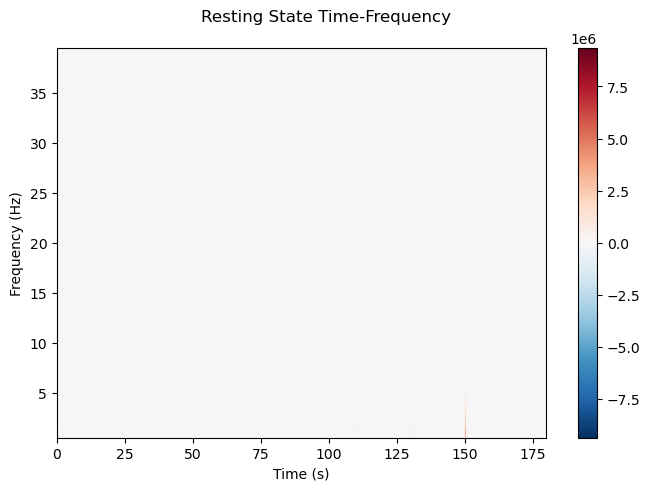

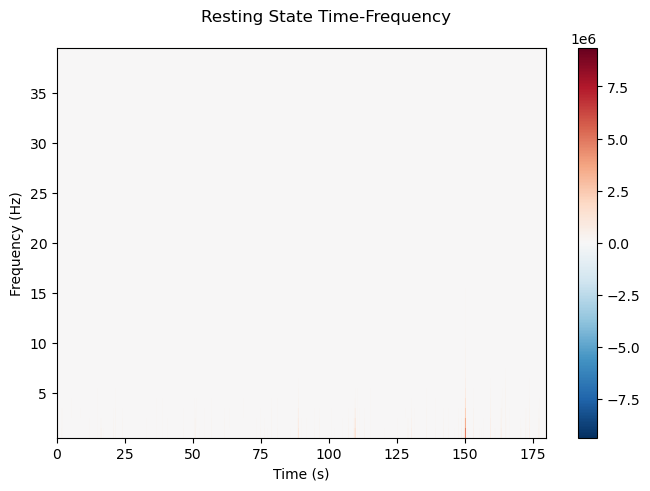

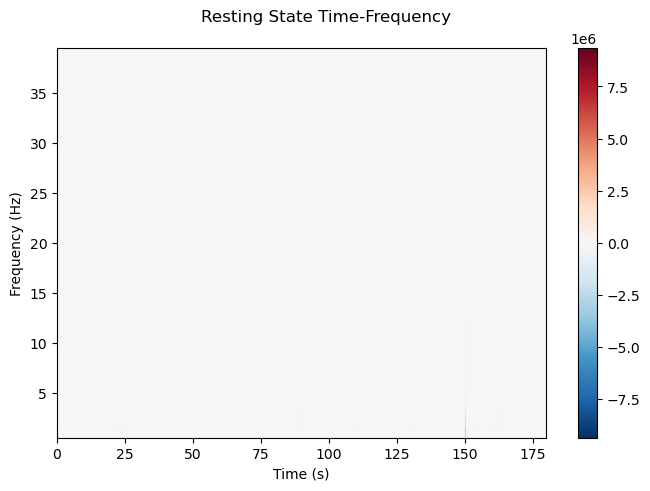

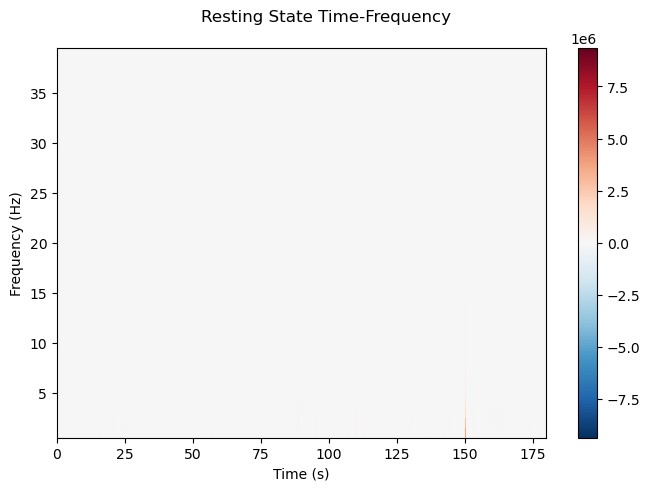

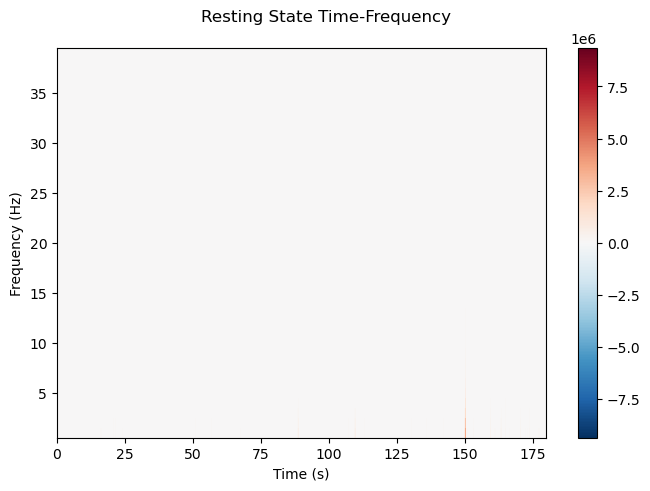

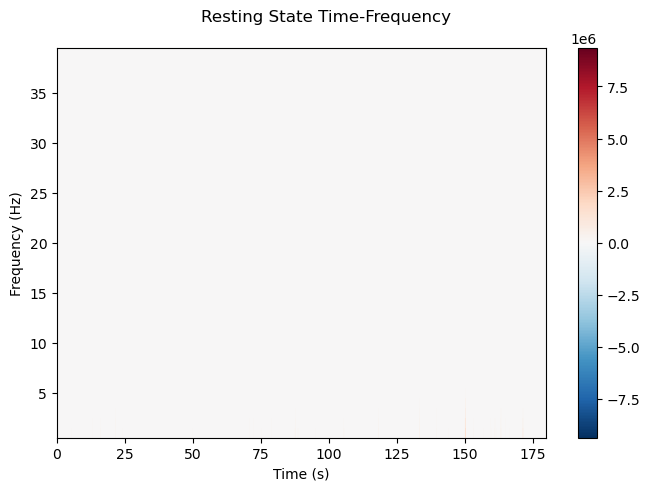

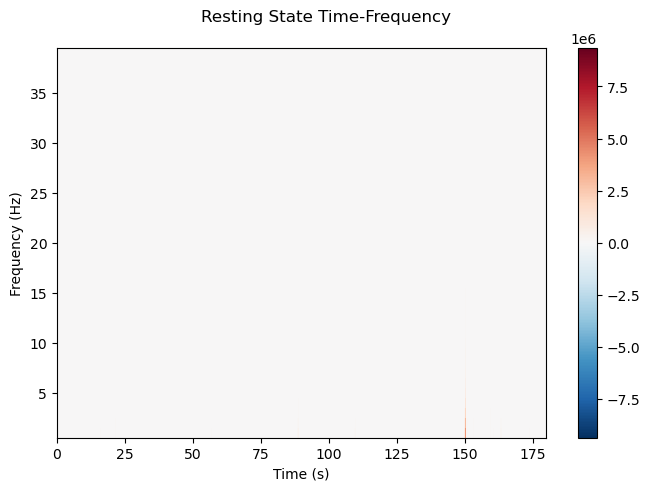

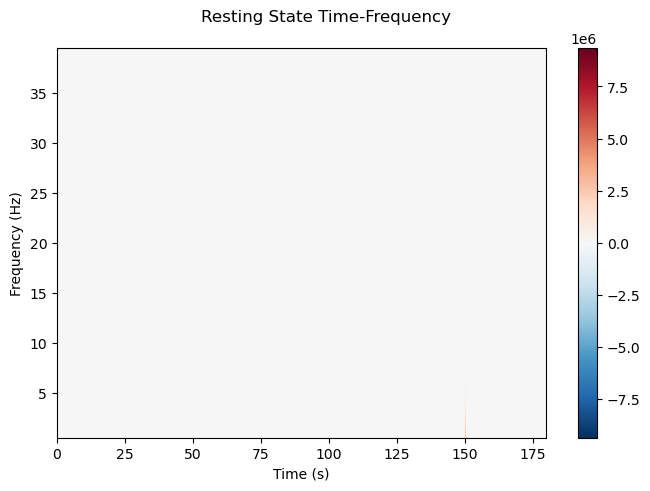

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

In [ ]:
power.plot(picks="eeg", mode="logratio", title="Resting State Time-Frequency")

In [ ]:
import numpy as np

frequencies = np.arange(1, 40, 1)  # Define frequency range
n_cycles = frequencies / 2.0  # Different number of cycle per frequency
power = mne.time_frequency.tfr_morlet(
    epochs,
    freqs=frequencies,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    decim=3,
    n_jobs=1,
)

NameError: name 'epochs' is not defined

In [ ]:
mne.time_frequency.compute_tfr(method=”morlet”)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 825 samples (1.650 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/var/folders/54/0yy_ylvj7tx247wkq0n07dnr0000gn/T/ipykernel_4132/1613471090.py:6: FutureWarning:

The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.

/var/folders/54/0yy_ylvj7tx247wkq0n07dnr0000gn/T/ipykernel_4132/1613471090.py:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

/Users/visser/miniforge3/envs/pain/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



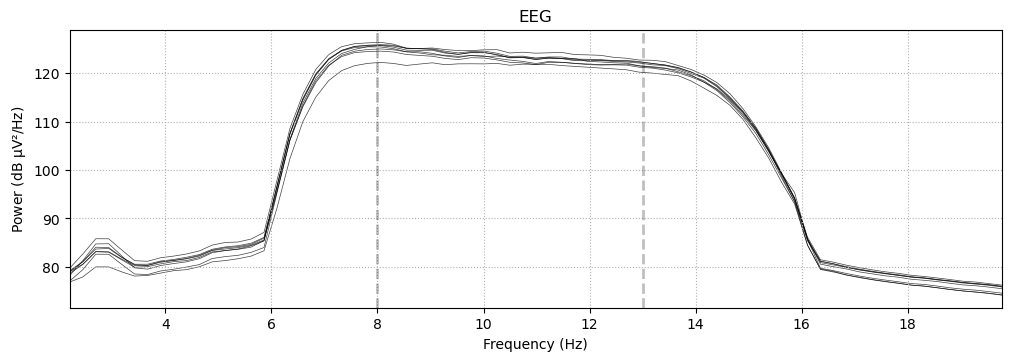

In [ ]:
# Apply filter for the Alpha band (8-13 Hz)
raw = eeg_mne.copy()
raw_alpha = raw.copy().filter(l_freq=8, h_freq=13)

# Plot the data to see the effect of the filter
raw_alpha.plot_psd(fmin=2, fmax=20)  # Plotting power spectral density

## Questions



In [ ]:
# - Artifacture removal for 8-channels? ICA not possible?
# - Power analysis? Which method? Window size? Only alpha? Or all bands?

## Plot

In [ ]:
merged = merge_datasets(eeg_raw, heat)
merged = scale_min_max(merged)
merged = interpolate(merged)
merged

NameError: name 'eeg_raw' is not defined

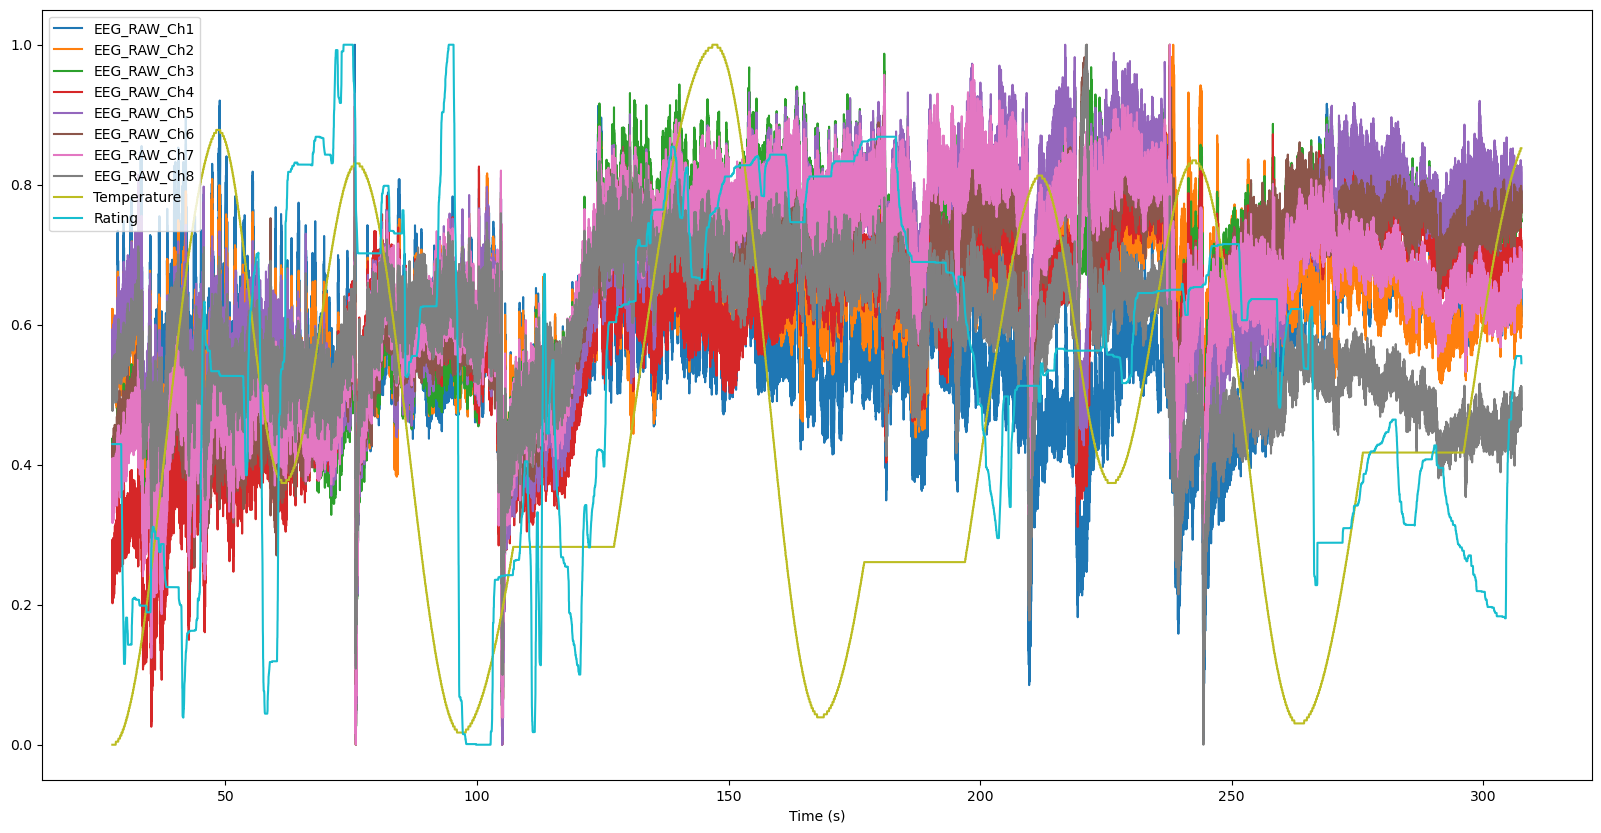

In [ ]:
plot_trial_matplotlib(merged, trial=0)

In [ ]:
plot_data_panel(merged)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

15:36:14 | WARNING | param.main | backend option not found for line plot with plotly; similar options include: []


INFO:bokeh.server.server:Starting Bokeh server version 3.3.3 (running on Tornado 6.3.3)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)
DEBUG:bokeh.server.tornado:These host origins can connect to the websocket: ['localhost:56626']
DEBUG:bokeh.server.tornado:Patterns are:
DEBUG:bokeh.server.tornado:  [('/favicon.ico',
DEBUG:bokeh.server.tornado:    <class 'bokeh.server.views.ico_handler.IcoHandler'>,
DEBUG:bokeh.server.tornado:    {'app': <bokeh.server.tornado.BokehTornado object at 0x14360ea50>}),
DEBUG:bokeh.server.tornado:   ('/?',
DEBUG:bokeh.server.tornado:    <class 'panel.io.server.DocHandler'>,
DEBUG:bokeh.server.tornado:    {'application_context': <bokeh.server.contexts.ApplicationContext object at 0x14b8e5fd0>,
DEBUG:bokeh.server.tornado:     'bokeh_websocket_path': '/ws'}),
DEBUG:bokeh.server.tornado:   ('/ws',
DEBUG:bokeh.server.tornado:    <class 'bokeh.server.views.ws.WSHandler'>,
DEBUG:bokeh.server.tornado:    {'application_context

Launching server at http://localhost:56626


INFO:tornado.access:200 GET / (127.0.0.1) 315.98ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/jquery/jquery.slim.min.js (127.0.0.1) 4.44ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=bf37f0b457d54fefb6ca8423c37db6ae69479153907d223a22f57d090b957998e75abda056bf5b0916a24f99930fa6df3b242a1a3a0986b549fbc966c1e04416 (127.0.0.1) 12.10ms
INFO:tornado.access:200 GET /static/js/bokeh-widgets.min.js?v=3c2dbaf226dc96c10bf3dfbcde30557363d2c16ec86bf2a10fb615e53d3971cbcf801e5051aa500292ec49f54812deae2aec9aaad0d97331534c89fe18ede89a (127.0.0.1) 12.37ms
INFO:tornado.access:200 GET /static/js/bokeh-tables.min.js?v=7849f2320ea741465a49857765873105e961ae71f15b481c5c529e76627d3706d004fe429b0472d4ba9e19fac7cf9be1874ba144e996beb84d89fe89958293f4 (127.0.0.1) 12.56ms
INFO:tornado.access:200 GET /static/extensions/panel/panel.min.js?v=0faff9f97292449eee32b81df88f812bca038d443c5a2254802df6108463f0fe (127.0.0.1) 15.85ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=f43c49e86

In [ ]:
import wonambi as wn

# generate data
data = wn.create_data(n_chan=2, signal="sine", amplitude=1)

traces = [go.Scatter(x=data.time[0], y=data(trial=0, chan="chan00"))]
layout = go.Layout(xaxis=dict(title="Time (s)"), yaxis=dict(title="Amplitude (V)"))

17:40:15 | DEBUG   | h5py._conv | Creating converter from 7 to 5
17:40:15 | DEBUG   | h5py._conv | Creating converter from 5 to 7
17:40:15 | DEBUG   | h5py._conv | Creating converter from 7 to 5
17:40:15 | DEBUG   | h5py._conv | Creating converter from 5 to 7


AttributeError: module 'wonambi' has no attribute 'create_data'

INFO:tornado.access:200 GET / (127.0.0.1) 296.61ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/jquery/jquery.slim.min.js (127.0.0.1) 1.07ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=f43c49e86dc38c1a13b9f41aad15fb57c3b2f70844817e5559b32d9e0a177c319416281f7bac18181198884ceb3998420b37b2b0199e0d0dc6485e34fc0a28dc (127.0.0.1) 5.41ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/plotlyplot/plotly-2.18.0.min.js (127.0.0.1) 66.91ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=bf37f0b457d54fefb6ca8423c37db6ae69479153907d223a22f57d090b957998e75abda056bf5b0916a24f99930fa6df3b242a1a3a0986b549fbc966c1e04416 (127.0.0.1) 0.64ms
INFO:tornado.access:200 GET /static/js/bokeh-widgets.min.js?v=3c2dbaf226dc96c10bf3dfbcde30557363d2c16ec86bf2a10fb615e53d3971cbcf801e5051aa500292ec49f54812deae2aec9aaad0d97331534c89fe18ede89a (127.0.0.1) 1.24ms
INFO:tornado.access:200 GET /static/js/bokeh-tables.min.js?v=7849f2320ea741465a49857765873105e961ae71f15b481c5c52